In [1]:
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [13]:
def sMAPC(y_forecast, y_forecast_previous):
    h = len(y_forecast)
    if h != len(y_forecast_previous):
        raise ValueError("Input lists must have the same length")
    s_mapc = 0
    for i in range(1, h):
        numerator = abs(y_forecast[i] - y_forecast_previous[i])
        denominator = abs(y_forecast[i]) + abs(y_forecast_previous[i])
        s_mapc += numerator / denominator
    s_mapc *= (200 / (h - 1))
    return s_mapc

def MAC(y_forecast, y_forecast_previous):
    h = len(y_forecast)
    if h != len(y_forecast_previous):
        raise ValueError("Input lists must have the same length")
    mac = 0
    for i in range(h):
        numerator = abs(y_forecast[i] - y_forecast_previous[i])
        mac += numerator
    mac /= (h)
    return mac

def get_power_norm(phase):
    power = pd.read_csv(f'debug_logs/real_power_gurobi_phase_{phase}_step_leap_1_forecast_step_1.csv')
    power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
    power = power.sort_values(by=['time_step', 'building'])
    power['building'] = power['building'].str[-1].astype(int)
    power = power[power['time_step'] != -1]
    lead_times = [f'+{i}h' for i in range(24)]
    power_norm = pd.DataFrame()
    for building in range(7):
        power_norm_temp = pd.DataFrame()
        power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
        power_norm_temp['building'] = building
        power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
        for i, lead_time in enumerate(lead_times):
            power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
        power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
    power_norm = power_norm.dropna()
    power_norm = power_norm.sort_values(by=['time_step', 'building'])
    power_norm = power_norm.drop(columns=['net_target'])
    power_norm = power_norm.set_index(['time_step', 'building'])
    return power_norm

def calculate_error_mac_series(phase_num, tog_forecast):
    MAC_steps = {}
    power_norm = get_power_norm(phase_num)
    num_buildings = power_norm.index.get_level_values('building').nunique()
    tog_forecast = tog_forecast.set_index(['time_step', 'building']).drop(columns=['scenario'])
    tog_forecast = tog_forecast.loc[power_norm.index]
    errors = power_norm - tog_forecast
    #errors.drop(columns=['building', 'scenario'], inplace=True)
    # return the building column
    for b_num in range(num_buildings):
        MAC_list = [0] * 24
        # slice on the building value 
        errors_temp = errors.loc[(slice(None), b_num), :]
        #errors_temp = errors_temp.drop(columns=['building', 'scenario'], inplace=True)
        for i, col in enumerate(errors_temp.columns[:-1]):
            MAC_list[i] = np.mean(np.abs(errors_temp.iloc[:,i] - errors_temp.iloc[:,i+1]))       
        MAC_steps[b_num] = np.mean(MAC_list)
    MAC = np.mean(list(MAC_steps.values()))
    return MAC

In [16]:
phase_num = 3
#sMAPC_steps = {}
MAC_steps = {}
#sMAPC_steps_dict = {}
MAC_steps_dict = {}
for step_forecast in range(1, 13):
    #sMAPC_steps[step_forecast] = {}
    MAC_steps[step_forecast] = {}
    tog_forecast = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv')
    MAC_steps_dict[step_forecast] = calculate_error_mac_series(phase_num, tog_forecast)
MAC_3  = pd.DataFrame.from_dict(MAC_steps_dict, orient='index', columns=['MAC'])

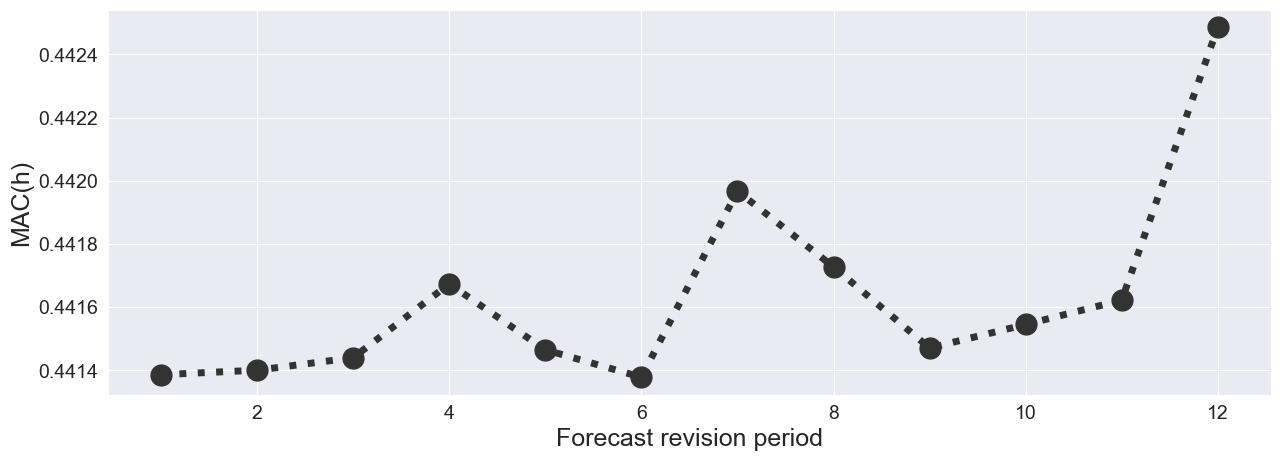

In [17]:
# seaborn darkgrid style style
sns.set_style("darkgrid")
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys())[:12], list(MAC_steps_dict.values())[:12], marker='o', linestyle='dotted', label='In-sample'
        , linewidth=5, markersize=15, color='#333333')
# make x ticks bigger
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.set_xlabel('Forecast revision period', fontsize=18)
ax.set_ylabel('MAC(h)', fontsize=18)
#ax.set_title(f'Forecast stability (MAC) vs forecast deployment step (In-sample)', fontsize=16)
plt.show()

In [18]:
phase_num = 1
#sMAPC_steps = {}
MAC_steps = {}
#sMAPC_steps_dict = {}
MAC_steps_dict = {}
for step_forecast in range(1, 13):
    #sMAPC_steps[step_forecast] = {}
    MAC_steps[step_forecast] = {}
    tog_forecast = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv')
    MAC_steps_dict[step_forecast] = calculate_error_mac_series(phase_num, tog_forecast)
MAC_3  = pd.DataFrame.from_dict(MAC_steps_dict, orient='index', columns=['MAC'])

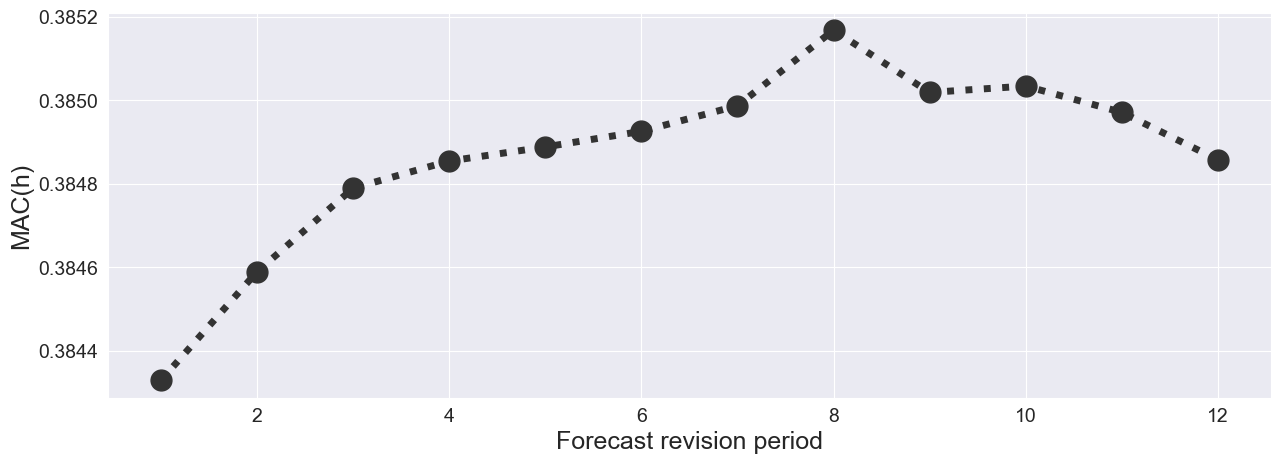

In [19]:
# seaborn darkgrid style style
sns.set_style("darkgrid")
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys())[:12], list(MAC_steps_dict.values())[:12], marker='o', linestyle='dotted', label='In-sample'
        , linewidth=5, markersize=15, color='#333333')
# color dark grey

# make x ticks bigger
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.set_xlabel('Forecast revision period', fontsize=18)
ax.set_ylabel('MAC(h)', fontsize=18)
#ax.set_title(f'Forecast stability (MAC) vs forecast deployment step (In-sample)', fontsize=16)
plt.show()